In [22]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Conv1D, Convolution1D, MaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



In [10]:
featuresdf = pd.read_pickle('pickled_64_feat.pkl')

### Create a test train split for the model using a 70/30 ratio.

In [11]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.3, random_state = 42)

# reshape the feature space to match the required input layer dimentions for the CNN
x_train = x_train.reshape(x_train.shape[0], 64,1)
x_test = x_test.reshape(x_test.shape[0], 64,1)


### Create the CNN model architecture

In [17]:
# Construct model 
ft_model = Sequential()
ft_model.add(Conv1D(filters=16, kernel_size=3, input_shape=(64,1), activation='relu'))
ft_model.add(MaxPooling1D(pool_size=(2)))
ft_model.add(Activation('relu'))

ft_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))#
ft_model.add(MaxPooling1D(pool_size=(2)))
ft_model.add(Activation('relu'))

ft_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
ft_model.add(Flatten())
ft_model.add(Dropout(0.3))

ft_model.add(Dense(units = 128, activation = 'relu'))
ft_model.add(Dropout(0.3))

ft_model.add(Dense(units = 84, activation = 'relu'))
ft_model.add(Dropout(0.3))
ft_model.add(Dense(units = 10, activation = 'relu'))
#model.add(GlobalAveragePooling2D())
ft_model.add(Dense(3, activation='softmax'))

ft_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 62, 16)            64        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 31, 16)            0         
_________________________________________________________________
activation_4 (Activation)    (None, 31, 16)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 29, 32)            1568      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 14, 32)            0         
_________________________________________________________________
activation_5 (Activation)    (None, 14, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 12, 64)           

In [19]:
# define a training function
def train(model,X_train, X_test, y_train, y_test):    

    # compile the model 
    model.compile(loss = 'kullback_leibler_divergence',metrics=['accuracy'],optimizer='adam')
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20, restore_best_weights=True )

    model.fit(X_train,y_train,batch_size= 10, epochs = 100, validation_data=(X_test,y_test),callbacks=[es])

In [20]:
train(ft_model,x_train,x_test,y_train,y_test)

Epoch 1/100
544/544 [==============================] - 2s 4ms/step - loss: 0.4703 - accuracy: 0.8125 - val_loss: 0.3012 - val_accuracy: 0.8885
Epoch 2/100
544/544 [==============================] - 2s 3ms/step - loss: 0.2952 - accuracy: 0.8838 - val_loss: 0.2111 - val_accuracy: 0.9215
Epoch 3/100
544/544 [==============================] - 2s 3ms/step - loss: 0.2238 - accuracy: 0.9197 - val_loss: 0.1590 - val_accuracy: 0.9438
Epoch 4/100
544/544 [==============================] - 2s 4ms/step - loss: 0.1646 - accuracy: 0.9425 - val_loss: 0.1781 - val_accuracy: 0.9365
Epoch 5/100
544/544 [==============================] - 2s 3ms/step - loss: 0.1384 - accuracy: 0.9513 - val_loss: 0.1476 - val_accuracy: 0.9498
Epoch 6/100
544/544 [==============================] - 2s 3ms/step - loss: 0.1191 - accuracy: 0.9568 - val_loss: 0.0814 - val_accuracy: 0.9785
Epoch 7/100
544/544 [==============================] - 2s 3ms/step - loss: 0.0954 - accuracy: 0.9687 - val_loss: 0.0790 - val_accuracy: 0.9768

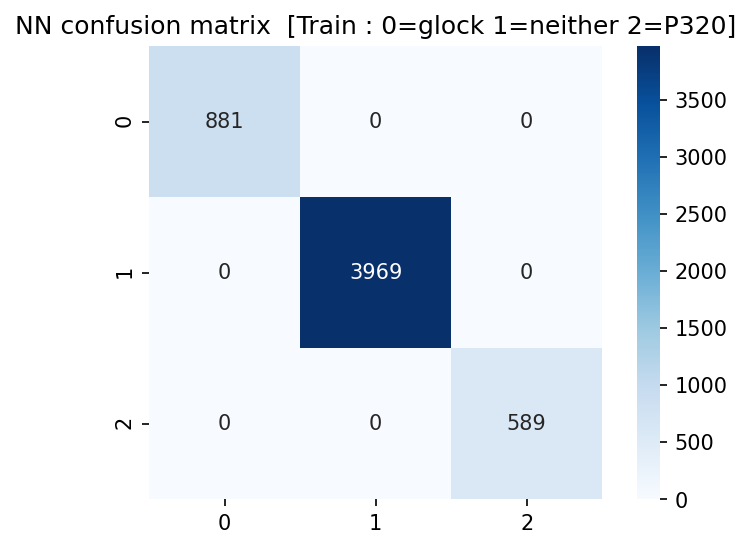

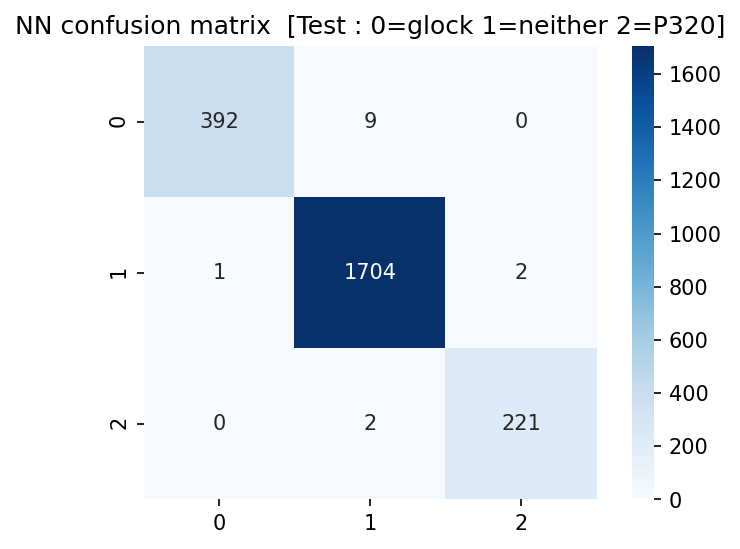

In [24]:


# Print confusion matrix for Gaussian
y_pred = (ft_model.predict(x_train)>.5)
GNB_confusion = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.title('NN confusion matrix  [Train : 0=glock 1=neither 2=P320]');

# Print confusion matrix for Gaussian

y_pred_t = (ft_model.predict(x_test)>.5)
rf_confusion = confusion_matrix(y_test.argmax(axis=1), y_pred_t.argmax(axis=1))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.title('NN confusion matrix  [Test : 0=glock 1=neither 2=P320]');



# Out of Sample Test

In [34]:
import glob
import librosa

file_paths = glob.glob("E:/Users/atag3/Documents/Gunshot_Data/New_Samples/*.wav")
labels = [os.path.basename(x) for x in glob.glob('E:/Users/atag3/Documents/Gunshot_Data/New_Samples/*.wav')]

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name,sr=44100)

        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=64)
        mfccs_processed = np.mean(mfccs.T,axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs_processed
        

0.6851851851851852


Text(0.5, 1.0, 'Out of Sample: [0=glock 1=neither 2=P320]')

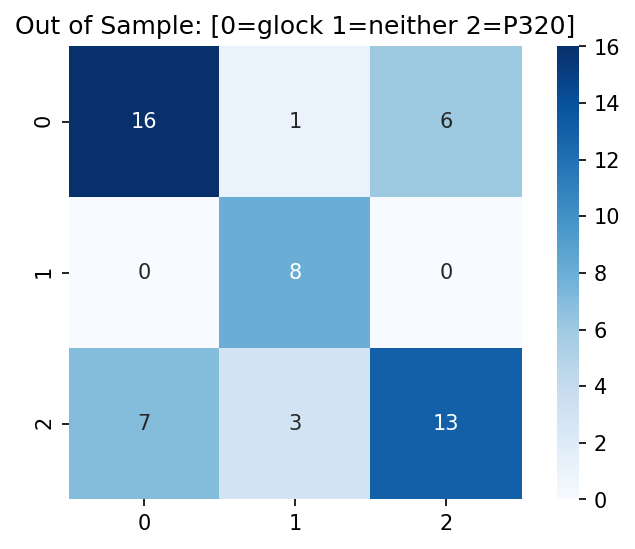

In [39]:
# Set the path to the full UrbanSound dataset 
features = []

# Iterate through each sound file and extract the features 
for i in range(len(file_paths)):
    
    class_label = labels[i].split("_")[0]
    data = extract_features(file_paths[i])
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

X = X.reshape(X.shape[0], 64,1)

y_pred_t = (ft_model.predict(X)>.5)
rf_confusion = confusion_matrix(yy.argmax(axis=1), y_pred_t.argmax(axis=1))
print(accuracy_score(yy.argmax(axis=1), y_pred_t.argmax(axis=1)))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.title('Out of Sample: [0=glock 1=neither 2=P320]')

## We end up with an out of sample accuracy of about 68% which may be improved on using additional features and audio samples to train on.